# Comparison of Classifiers

## Introduction

__Classification__ is a supervised machine learning problem where the algorithm or model predicts the class of a sample from it's features. Here  the __target__ _y_ is a categorical variable rather than a real variable like in a Regression problem. Statistically, the problem is to build a **decision boundary** for each class which will **separate that class from the rest of the  other classes**. If a classification problem has only two classes, then it is called a __Binary Classification__ problem and in this scenario we only require a single decision boundary to separate both classes.

Based on the nature of the decision boundary, there are mainly two types of classifiers:

- **Linear Classifiers**: (Ex. Logistic Regression, Support Vector Machine with Linear Kernel) The decision boundary is a straight line separating the classes. These models are fairly straightforward and are very popular for their simplicity.

- **Nonlinear Classifiers**: (Ex. k-NN, Decision Tree, Random Forest, Support Vector Machines with nonlinear kernels) This is a much broader and more complex category of classifiers. These models are used for solving complex machine learning problems and also when the data is not separable by a straight line.

In this Notebook, we will go over some of the widely used classifiers:

1. Logistic Regression

2. Support Vector Machines with Radial Basis Kernel

3. k-Nearest Neighbors

4. Decision Tree Classifier

5. Random Forest Classifier

6. Gaussian Naïve Bayes Classifier

## Evaluation of Model

Once our model is trained, now a question arises, how to evaluate the model? how to compare two different classifiers? 

There are numerus methods to evaluate and compare classification models but the in this notebook, we will be using:

1. Confusion Matrix

2. Sensitivity or Recall

3. Specificity

4. AUC - ROC Curve

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Train-Test Split
from sklearn.model_selection import train_test_split
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
# For model evaulation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

# The Dataset

## About

A car manufacturer wants to build a social media advertisement campaign for a new SUV. The company will use data from it's existing customer database to build a model and use it to target ads to users who have been predicted to purchase an SUV.

## Features

The dataset contains 400 observations on the following features

1. _User ID_: (`int`) User ID of customer
2. _Gender_: (`str`) Male or Female
3. _Age_: (`int`) Age of customer during purchase
4. _EstimatedSalary_: (`int`) Predicted Salary in USD of customer during purchase
5. _Purchased_: (`int`) If the customer purchased an SUV then the value is $1$ and $0$ otherwise

__Note:__ The dataset does not contain missing or duplicate observations.

In [2]:
df = pd.read_csv("SUV_Purchase.csv")
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


# Data Preprocessing

## Cleaning

- _User ID_ does not contribute anything to the model
- _Gender_ is in String format whoch needs to be transformed to integer

In [4]:
# Class Names
class_names = {'Not Purchased':0, 'Purchased':1}
# Remove User ID
df.drop('User ID', axis = 1, inplace = True)
# Encoding Gender
df.replace({'Male':1, 'Female':0}, inplace = True)

df.head()

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


## Feature Scaling

Since classifiers like k-NN, SVM and Logistic Regression are sensitive to the variability of the Features, we must bring all the Features to a comparable scale

In [5]:
sc = StandardScaler()
df[['Age','EstimatedSalary']] = sc.fit_transform(df.loc[:, ['Age','EstimatedSalary']])
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,1,-1.781797,-1.490046,0
1,1,-0.253587,-1.460681,0
2,0,-1.113206,-0.785290,0
3,0,-1.017692,-0.374182,0
4,1,-1.781797,0.183751,0


## Train-Test Split

We are going to  split the dataset into training set and testing set with a test_size of $20\%$

In [6]:
# variable Separation
X = df.drop('Purchased', axis = 1).values
y = df.loc[:, 'Purchased'].values
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# results
print("X_train: ",np.shape(X_train))
print("y_train: ",np.shape(y_train))
print('X_test:',np.shape(X_test))
print('y_test:',np.shape(y_test))

X_train:  (320, 3)
y_train:  (320,)
X_test: (80, 3)
y_test: (80,)


# Dimensionality Reduction

Here we want to build a classifier using only 2 features but we have 3. Using __Principal Component Analysis__ we will reduce the 3 features into 2 principal components such that maximum variation is captured by the PCA.

In [7]:
# PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
## results of 
print('Variance Captured by PCA')
for i in np.arange(pca.n_components_):
    print("PC{0:d}: {1:.1f}%".format(i+1, 100*pca.explained_variance_ratio_[i]))

Variance Captured by PCA
PC1: 52.2%
PC2: 37.2%


# Defining functions for Model evaluation

## AUC-ROC Curve

In [8]:
def AUC_ROC(model,X_train, X_test, y_train, y_test) :
    # Training Data
    y_train_prob = model.predict_proba(X_train)
    fpr1, tpr1, thres1 = roc_curve(y_train, y_train_prob[:,1], pos_label = 1)
    auc1 = auc(fpr1, tpr1)
    # testing Data
    y_test_prob = model.predict_proba(X_test)
    fpr2, tpr2, thres2 = roc_curve(y_test, y_test_prob[:,1], pos_label = 1)
    auc2= auc(fpr2, tpr2)
    #plotting
    plt.figure(figsize = (8,6))
    plt.plot(fpr1, tpr1, label = "Training: AUC-ROC = {0:.3f}".format(auc1),
             color = "tab:orange")
    plt.plot(fpr2, tpr2, label = "Testing: AUC-ROC = {0:.3f}".format(auc2),
             color = 'tab:blue')
    plt.plot(fpr1, fpr1, label = "FPR = TPR", color = 'black', linewidth=0.5)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title("ROC Curve for " + model.__class__.__name__)
    plt.legend(loc = "lower right")
    plt.grid(which = 'both', axis = 'both')
    plt.show()
    pass

## Confusion Matrix

In [9]:
def cm_Heatmap(y_true, y_pred, class_name = np.unique(y_train)) :
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, columns = class_name, index = class_name)
    # Plotting
    plt.figure(figsize = (8,6))
    sns.heatmap(cm, annot = True, annot_kws = {'size': 20}, fmt = 'd', cmap = 'Greens')
    plt.xlabel('Observed Class')
    plt.ylabel('Predicted Class')
    plt.title('Confusion Matrix')
    plt.show()
    pass

# Classification Models

In [10]:
# Training the Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
# Training Reprto
print(classification_report(y_train, log_reg.predict(X_train), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.85      0.93      0.88       207
    Purchased       0.84      0.69      0.76       113

     accuracy                           0.84       320
    macro avg       0.84      0.81      0.82       320
 weighted avg       0.84      0.84      0.84       320



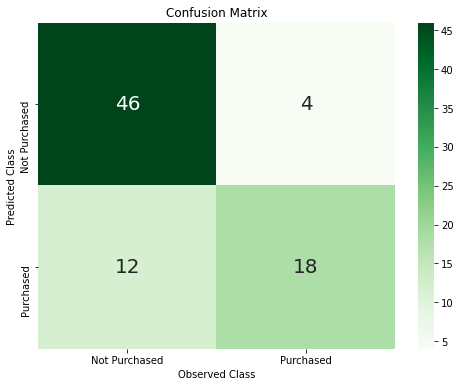

In [11]:
# test data
cm_Heatmap(y_test, log_reg.predict(X_test), class_names)

In [12]:
# Classification report
print(classification_report(y_test, log_reg.predict(X_test), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.79      0.92      0.85        50
    Purchased       0.82      0.60      0.69        30

     accuracy                           0.80        80
    macro avg       0.81      0.76      0.77        80
 weighted avg       0.80      0.80      0.79        80



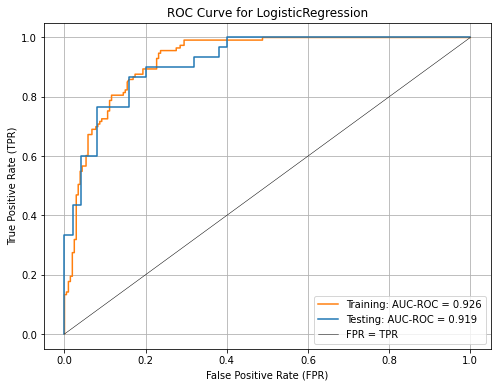

In [13]:
AUC_ROC(log_reg, X_train, X_test, y_train, y_test)

In [14]:
# Training model
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
# Training report
print(classification_report(y_train, knn.predict(X_train), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.95      0.93      0.94       207
    Purchased       0.88      0.90      0.89       113

     accuracy                           0.92       320
    macro avg       0.91      0.92      0.92       320
 weighted avg       0.92      0.92      0.92       320



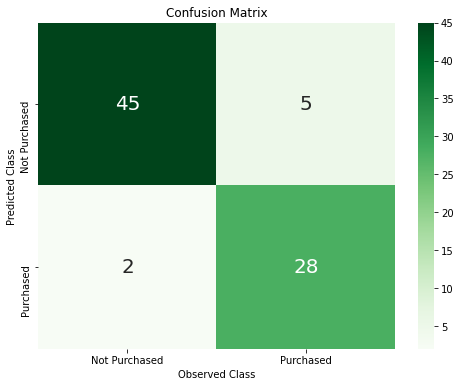

In [15]:
cm_Heatmap(y_test, knn.predict(X_test), class_names)

In [16]:
print(classification_report(y_test, knn.predict(X_test), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.96      0.90      0.93        50
    Purchased       0.85      0.93      0.89        30

     accuracy                           0.91        80
    macro avg       0.90      0.92      0.91        80
 weighted avg       0.92      0.91      0.91        80



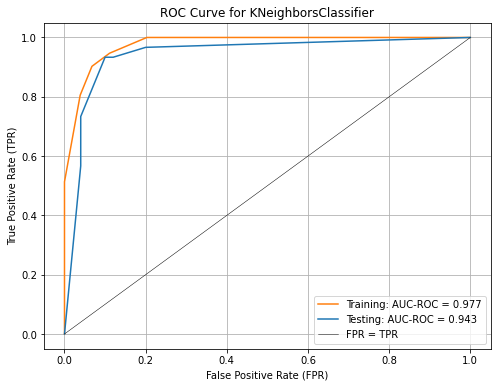

In [17]:
AUC_ROC(knn, X_train, X_test, y_train, y_test)

In [18]:
# Training model
dtc = DecisionTreeClassifier(max_depth = 4)
dtc.fit(X_train, y_train)
## Trainign report
print(classification_report(y_train, dtc.predict(X_train), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.94      0.96      0.95       207
    Purchased       0.93      0.89      0.91       113

     accuracy                           0.94       320
    macro avg       0.93      0.93      0.93       320
 weighted avg       0.94      0.94      0.94       320



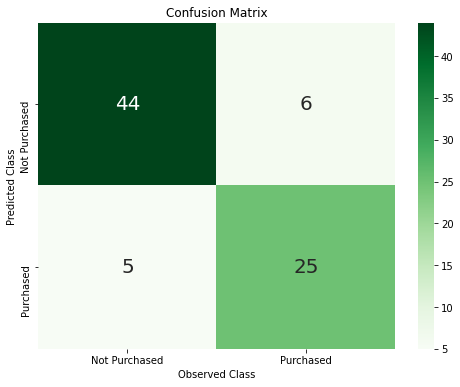

In [19]:
# test data
cm_Heatmap(y_test, dtc.predict(X_test), class_names)

In [20]:
# Classification report
print(classification_report(y_test, dtc.predict(X_test), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.90      0.88      0.89        50
    Purchased       0.81      0.83      0.82        30

     accuracy                           0.86        80
    macro avg       0.85      0.86      0.85        80
 weighted avg       0.86      0.86      0.86        80



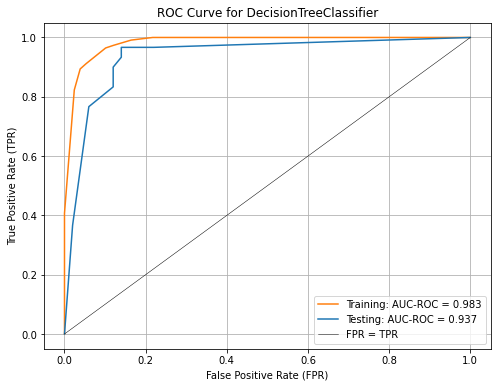

In [21]:
AUC_ROC(dtc, X_train, X_test, y_train, y_test)

In [22]:
# Training model
rfc = RandomForestClassifier(n_estimators = 50, max_depth = 3)
rfc.fit(X_train, y_train)
# Training report
print(classification_report(y_train, rfc.predict(X_train), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.95      0.94      0.94       207
    Purchased       0.89      0.91      0.90       113

     accuracy                           0.93       320
    macro avg       0.92      0.92      0.92       320
 weighted avg       0.93      0.93      0.93       320



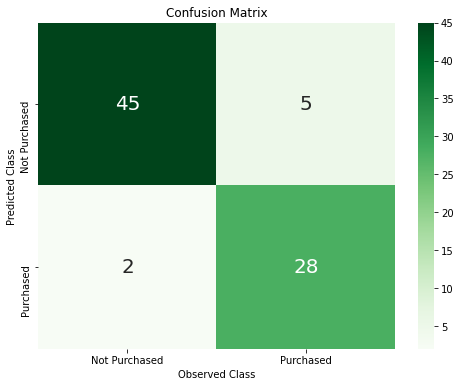

In [23]:
cm_Heatmap(y_test, rfc.predict(X_test), class_names)

In [24]:
print(classification_report(y_test, rfc.predict(X_test), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.96      0.90      0.93        50
    Purchased       0.85      0.93      0.89        30

     accuracy                           0.91        80
    macro avg       0.90      0.92      0.91        80
 weighted avg       0.92      0.91      0.91        80



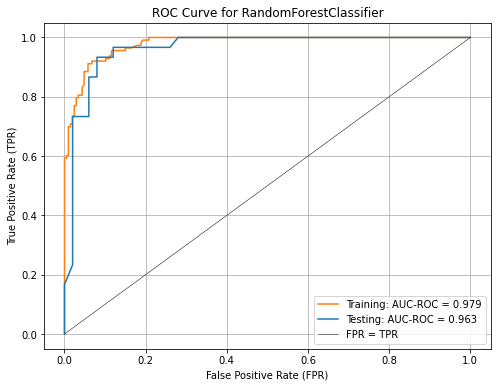

In [25]:
AUC_ROC(rfc, X_train, X_test, y_train, y_test)

In [26]:
# Training model
nbc = GaussianNB(priors = np.array([0.5, 0.5]))
nbc.fit(X_train, y_train)
# Training report
print(classification_report(y_train, nbc.predict(X_train), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.94      0.91      0.93       207
    Purchased       0.84      0.90      0.87       113

     accuracy                           0.91       320
    macro avg       0.89      0.91      0.90       320
 weighted avg       0.91      0.91      0.91       320



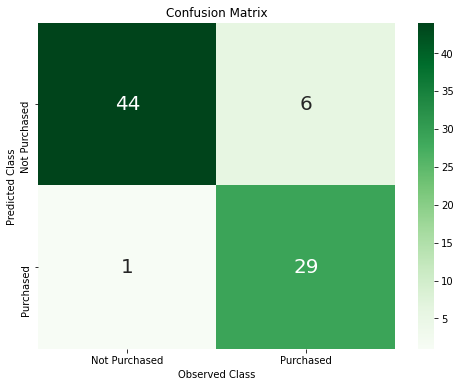

In [27]:
cm_Heatmap(y_test, nbc.predict(X_test), class_names)

In [28]:
print(classification_report(y_test, nbc.predict(X_test), target_names = class_names))

               precision    recall  f1-score   support

Not Purchased       0.98      0.88      0.93        50
    Purchased       0.83      0.97      0.89        30

     accuracy                           0.91        80
    macro avg       0.90      0.92      0.91        80
 weighted avg       0.92      0.91      0.91        80



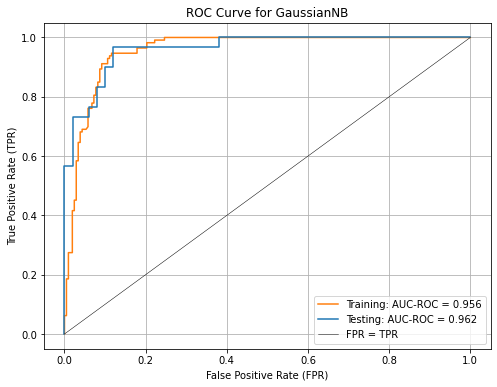

In [29]:
AUC_ROC(nbc, X_train, X_test, y_train, y_test)